<a href="https://colab.research.google.com/github/davidfague/Stylized-ReducedOrder-L5-Model/blob/main/L5_Morphology_Calculations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install neuron

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 15.0 MB 4.3 MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/Stylized-Cell-model/

/content/drive/MyDrive/Stylized-Cell-model


In [4]:
from neuron import h
import pandas as pd
import numpy as np
from scipy.stats import lognorm
import math
import os
from stylized_module.stylized_cell import Stylized_Cell
from stylized_module.ecp import EcpMod, newposition
from stylized_module.recorder import Recorder
from stylized_module.point_current import Point_current
from pathlib import Path

In [5]:
%ls

 active_channel_model_example.ipynb       i_nmda_report.hdf5
 active_channel_model_groundtruth.ipynb  'L5 Individual Basal Paths'/
 ca_df.csv                               'L5 Individual Tuft Paths'/
 Elec_distance.svg                        L5Morphology.swc
 example_model_inject_waveform.ipynb      L5Morphology.swc.txt
 exc_syns.svg                             mechanisms/
 fig1A.svg                                na_df.csv
 fig2A.svg                                nmda_df.csv
 fig2B.svg                                Segments.hdf5
 fig2C.svg                                Spikes.hdf5
 fig2D.svg                                stylized_cell_figure.ipynb
 fig2E.svg                                stylizedcell.pdf
 fig2F.svg                                stylized_module/
 fig2G.svg                                syn_parameters.csv
 geom_parameters.csv                      syn_parameters.gsheet
 geom_standard.csv                        templates/
 gNaTa_report.hdf5                        T

#Basal Dendrites
##Calculate Mean Length of unique Dendritic Paths and mean ratio across sections

In [6]:
# define proportions for sectioning (should sum to 1)
prox_prop = 0.2
mid_prop = 0.3
dist_prop = 0.5


txt_folder = Path('L5 Individual Basal Paths/').rglob('*.swc') #select folder in google drive
files = [x for x in txt_folder] #list files in folder
dend_pathlengths=[] #list for individual path lengths
skipcount=0 #count to verify the NeuTube line is skipped
prox_r=[]
mid_r=[]
dist_r=[]
prox_d=[]
mid_d=[]
dist_d=[]

for name in files: #iterate through files
  #lists for coordinates, radii, and segment pathlengths
  segx=[]
  segy=[]
  segz=[]
  segr=[]
  seg_d=[]
  seg_pathlength=[0] #list for distance between segments
  with open(name) as f:
      lines=f.read().splitlines()
      for line in lines:
        x=line.split()
        try:
            segx.append(float(x[2]))
            segy.append(float(x[3]))
            segz.append(float(x[4]))
            if not x[5]==0.9875:
              segr.append(float(x[5]))
            else:
              print(x[5])
        except:
              skipcount=skipcount+1 #skip if line isn't segment values (NeuTube .swc files begin with a different line)
      for i in range(1,len(segx)):
        seg_d.append((((-segx[i-1]+segx[i])**2)+((-segy[i-1]+segy[i])**2)+((-segz[i-1]+segz[i])**2))**0.5) #calculate distance from last segment
        seg_pathlength.append(sum(seg_d)) #calculate and add segment pathlength from 0 to list 
      dend_pathlength=seg_pathlength[-1] #take last segment path length as dendrite path length
      dend_pathlengths.append(dend_pathlength) # add to list

      # define proportions for sectioning paths
      prox_L=prox_prop*dend_pathlength
      mid_L=mid_prop*dend_pathlength
      dist_L=dist_prop*dend_pathlength
      # caclulate bounds for sectiong
      proxend=prox_L
      midend=prox_L+mid_L
      #section by criteria
      for i in range(len(segr)):
        if seg_pathlength[i] < proxend:
          prox_r.append(segr[i])
          prox_d.append(seg_pathlength[i]/dend_pathlength)
        elif seg_pathlength[i] > proxend and seg_pathlength[i] < midend:
          mid_r.append(segr[i])
          mid_d.append(seg_pathlength[i]/dend_pathlength)
        elif seg_pathlength[i] > midend:
          dist_r.append(segr[i])
          dist_d.append(seg_pathlength[i]/dend_pathlength)

#print('The NeuTube line was skipped correctly:',skipcount==len(files))
avgdend_L=np.mean(dend_pathlengths)
proxdend_L=round(prox_prop*avgdend_L)
middend_L=round(mid_prop*avgdend_L)
distdend_L=round(dist_prop*avgdend_L)
avgprox_r=np.mean(prox_r)
avgmid_r=np.mean(mid_r)
avgdist_r=np.mean(dist_r)
print('The mean dendrite  length is',avgdend_L)
print('The proximal section length should be',proxdend_L)
print('The middle section length should be',middend_L)
print('The distal section length should be',distdend_L)
print('The mean proximal section radius is',avgprox_r)
print('The mean middle section radius is',avgmid_r)
print('The mean distal section radius is',avgdist_r)
print(prox_r)

The mean dendrite  length is 196.23182655283873
The proximal section length should be 39
The middle section length should be 59
The distal section length should be 98
The mean proximal section radius is 0.6478574363188168
The mean middle section radius is 0.33488148354712777
The mean distal section radius is 0.2539156062874252
[1.355, 1.355, 1.355, 1.355, 1.355, 1.355, 1.355, 1.245, 1.245, 1.245, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 0.565, 0.565, 0.565, 0.565, 0.565, 0.565, 0.565, 0.565, 0.565, 0.565, 0.565, 0.565, 0.565, 0.565, 0.565, 0.565, 0.565, 0.565, 0.565, 0.565, 0.51, 0.51, 0.51, 0.565, 0.565, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 1.355, 1.355, 1.355, 1.355, 1.355, 1.355, 1.355, 1.245, 1.245, 1.245, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.395, 0.395, 0.395, 0.395, 0.395, 0.395, 1.355, 1.355, 1.355, 1.355, 1.355, 1.3

##Plot Basal Radii by normalized length of dendritic path

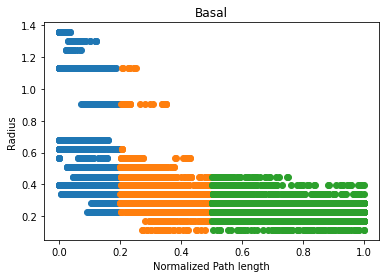

In [7]:
#plot radii
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.set_title('Basal')
ax.set_ylabel('Radius')
ax.set_xlabel('Normalized Path length')
plt.scatter(prox_d,prox_r)  # blue
plt.scatter(mid_d,mid_r) # orange
plt.scatter(dist_d,dist_r) # green

#Tuft Dendrites
##Calculate Mean Length of unique Dendritic Paths and mean ratio across sections

In [8]:
# define proportions for sectioning (should sum to 1)
prox_prop = 0.2
mid_prop = 0.4
dist_prop = 0.4


txt_folder = Path('L5 Individual Tuft Paths/').rglob('*.swc') #select folder in google drive
files = [x for x in txt_folder] #list files in folder
dend_pathlengths=[] #list for individual path lengths
skipcount=0 #count to verify the NeuTube line is skipped
prox_r=[]
mid_r=[]
dist_r=[]
prox_d=[]
mid_d=[]
dist_d=[]

for name in files: #iterate through files
  #lists for coordinates, radii, and segment pathlengths
  segx=[]
  segy=[]
  segz=[]
  segr=[]
  seg_d=[]
  seg_pathlength=[0] #list for distance between segments
  with open(name) as f:
      lines=f.read().splitlines()
      for line in lines:
        x=line.split()
        try:
            segx.append(float(x[2]))
            segy.append(float(x[3]))
            segz.append(float(x[4]))
            if not x[5]==0.9875:
              segr.append(float(x[5]))
            else:
              print(x[5])
        except:
              skipcount=skipcount+1 #skip if line isn't segment values (NeuTube .swc files begin with a different line)
      for i in range(1,len(segx)):
        seg_d.append((((-segx[i-1]+segx[i])**2)+((-segy[i-1]+segy[i])**2)+((-segz[i-1]+segz[i])**2))**0.5) #calculate distance from last segment
        seg_pathlength.append(sum(seg_d)) #calculate and add segment pathlength from 0 to list 
      dend_pathlength=seg_pathlength[-1] #take last segment path length as dendrite path length
      dend_pathlengths.append(dend_pathlength) # add to list

      # define proportions for sectioning paths
      prox_L=prox_prop*dend_pathlength
      mid_L=mid_prop*dend_pathlength
      dist_L=dist_prop*dend_pathlength
      # caclulate bounds for sectiong
      proxend=prox_L
      midend=prox_L+mid_L
      #section by criteria
      for i in range(len(segr)):
        if seg_pathlength[i] < proxend:
          prox_r.append(segr[i])
          prox_d.append(seg_pathlength[i]/dend_pathlength)
        elif seg_pathlength[i] > proxend and seg_pathlength[i] < midend:
          mid_r.append(segr[i])
          mid_d.append(seg_pathlength[i]/dend_pathlength)
        elif seg_pathlength[i] > midend:
          dist_r.append(segr[i])
          dist_d.append(seg_pathlength[i]/dend_pathlength)

#print('The NeuTube line was skipped correctly:',skipcount==len(files))
avgdend_L=np.mean(dend_pathlengths)
proxdend_L=round(prox_prop*avgdend_L)
middend_L=round(mid_prop*avgdend_L)
distdend_L=round(dist_prop*avgdend_L)
avgprox_r=np.mean(prox_r)
avgmid_r=np.mean(mid_r)
avgdist_r=np.mean(dist_r)
print('The mean dendrite  length is',avgdend_L)
print('The proximal section length should be',proxdend_L)
print('The middle section length should be',middend_L)
print('The distal section length should be',distdend_L)
print('The mean proximal section radius is',avgprox_r)
print('The mean middle section radius is',avgmid_r)
print('The mean distal section radius is',avgdist_r)
print(prox_r)

The mean dendrite  length is 525.3310956492976
The proximal section length should be 105
The middle section length should be 210
The distal section length should be 210
The mean proximal section radius is 0.38775545350172214
The mean middle section radius is 0.30256273525721455
The mean distal section radius is 0.25999056247640623
[0.9875, 0.395, 0.395, 0.395, 0.395, 0.395, 0.395, 0.395, 0.395, 0.395, 0.395, 0.395, 0.395, 0.395, 0.395, 0.395, 0.395, 0.395, 0.395, 0.395, 0.395, 0.395, 0.395, 0.395, 0.395, 0.395, 0.395, 0.395, 0.395, 0.395, 0.395, 0.395, 0.395, 0.395, 0.395, 0.395, 0.395, 0.395, 0.395, 0.395, 0.395, 0.395, 0.395, 0.395, 0.395, 0.395, 0.395, 0.395, 0.395, 0.395, 0.395, 0.395, 0.395, 0.395, 0.395, 0.395, 0.395, 0.395, 0.395, 0.285, 0.285, 0.285, 0.285, 0.285, 0.285, 0.285, 0.285, 0.285, 0.285, 0.285, 0.285, 0.285, 0.9875, 0.395, 0.395, 0.395, 0.395, 0.395, 0.395, 0.395, 0.395, 0.395, 0.395, 0.395, 0.395, 0.395, 0.395, 0.395, 0.395, 0.395, 0.395, 0.395, 0.395, 0.395, 0.395,

##Plot Tuft Radii by normalized length of dendritic path

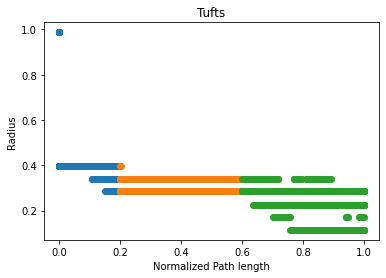

In [9]:
#plot radii
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.set_title('Tufts')
ax.set_ylabel('Radius')
ax.set_xlabel('Normalized Path length')
plt.scatter(prox_d,prox_r)  # blue
plt.scatter(mid_d,mid_r) # orange
plt.scatter(dist_d,dist_r) # green


#Trunk
##Calculate Length of Trunk Path and mean ratio across defined sections

In [10]:
# define proportions for sectioning (should sum to 1)
prox_prop = 2/7
mid_prop = 3/7
dist_prop = 2/7

dend_pathlengths=[] #list for individual path lengths
skipcount=0 #count to verify the NeuTube line is skipped
prox_r=[]
mid_r=[]
dist_r=[]
prox_d=[]
mid_d=[]
dist_d=[]
#lists for coordinates, radii, and segment pathlengths
segx=[]
segy=[]
segz=[]
segr=[]
seg_d=[]
seg_pathlength=[0] #list for distance between segments
with open('Trunk.swc') as f:
    lines=f.read().splitlines()
    for line in lines:
        x=line.split()
        try:
            segx.append(float(x[2]))
            segy.append(float(x[3]))
            segz.append(float(x[4]))
            if not x[5]==0.9875:
              segr.append(float(x[5]))
            else:
              print(x[5])
        except:
              skipcount=skipcount+1 #skip if line isn't segment values (NeuTube .swc files begin with a different line)
    for i in range(1,len(segx)):
        seg_d.append((((-segx[i-1]+segx[i])**2)+((-segy[i-1]+segy[i])**2)+((-segz[i-1]+segz[i])**2))**0.5) #calculate distance from last segment
        seg_pathlength.append(sum(seg_d)) #calculate and add segment pathlength from 0 to list 
    dend_pathlength=seg_pathlength[-1] #take last segment path length as dendrite path length
    dend_pathlengths.append(dend_pathlength) # add to list

      # define proportions for sectioning paths
    prox_L=prox_prop*dend_pathlength
    mid_L=mid_prop*dend_pathlength
    dist_L=dist_prop*dend_pathlength
      # caclulate bounds for sectiong
    proxend=prox_L
    midend=prox_L+mid_L
      #section by criteria
    for i in range(len(segr)):
        if seg_pathlength[i] < proxend:
          prox_r.append(segr[i])
          prox_d.append(seg_pathlength[i]/dend_pathlength)
        elif seg_pathlength[i] > proxend and seg_pathlength[i] < midend:
          mid_r.append(segr[i])
          mid_d.append(seg_pathlength[i]/dend_pathlength)
        elif seg_pathlength[i] > midend:
          dist_r.append(segr[i])
          dist_d.append(seg_pathlength[i]/dend_pathlength)

#print('The NeuTube line was skipped correctly:',skipcount==len(files))
avgdend_L=np.mean(dend_pathlengths)
proxdend_L=round(prox_prop*avgdend_L)
middend_L=round(mid_prop*avgdend_L)
distdend_L=round(dist_prop*avgdend_L)
avgprox_r=np.mean(prox_r)
avgmid_r=np.mean(mid_r)
avgdist_r=np.mean(dist_r)
print('The mean dendrite  length is',avgdend_L)
print('The proximal section length should be',proxdend_L)
print('The middle section length should be',middend_L)
print('The distal section length should be',distdend_L)
print('The mean proximal section radius is',avgprox_r)
print('The mean middle section radius is',avgmid_r)
print('The mean distal section radius is',avgdist_r)
print(prox_r)

The mean dendrite  length is 950.0556620450953
The proximal section length should be 271
The middle section length should be 407
The distal section length should be 271
The mean proximal section radius is 1.5274671052631579
The mean middle section radius is 1.2789379474940334
The mean distal section radius is 1.0426598837209302
[2.4, 2.4, 2.4, 2.4, 2.4, 2.4, 2.4, 2.4, 2.4, 2.4, 2.4, 2.4, 2.4, 2.4, 2.4, 2.4, 2.4, 2.4, 2.4, 2.4, 2.4, 2.4, 2.4, 2.4, 2.4, 2.4, 2.4, 2.4, 2.4, 2.4, 2.4, 2.4, 2.4, 2.4, 2.4, 2.4, 2.4, 2.4, 2.4, 1.975, 1.975, 1.975, 1.975, 1.975, 1.975, 1.975, 1.975, 1.975, 1.975, 1.975, 1.975, 1.975, 1.55, 1.55, 1.55, 1.55, 1.55, 1.55, 1.55, 1.55, 1.55, 1.55, 1.55, 1.55, 1.55, 1.55, 1.55, 1.55, 1.55, 1.55, 1.55, 1.55, 1.55, 1.55, 1.55, 1.55, 1.55, 1.55, 1.55, 1.55, 1.55, 1.55, 1.55, 1.55, 1.55, 1.55, 1.55, 1.55, 1.55, 1.55, 1.55, 1.55, 1.55, 1.55, 1.55, 1.55, 1.55, 1.55, 1.55, 1.55, 1.55, 1.55, 1.55, 1.55, 1.55, 1.55, 1.55, 1.55, 1.55, 1.55, 1.55, 1.55, 1.55, 1.55, 1.55, 1.55,

##Plot Trunk Radii by normalized length of Trunk path

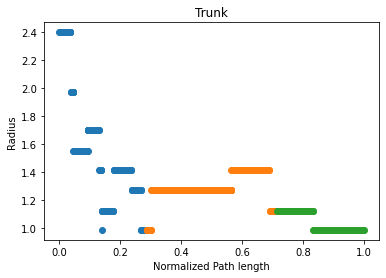

In [11]:
#plot radii
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.set_title('Trunk')
ax.set_ylabel('Radius')
ax.set_xlabel('Normalized Path length')
plt.scatter(prox_d,prox_r)  # blue
plt.scatter(mid_d,mid_r) # orange
plt.scatter(dist_d,dist_r) # green

Old Code

In [12]:
# sum_soma_r=0
# sum_soma_x=0
# sum_soma_y=0
# sum_soma_z=0
# sum_basal_r=0
# sum_basal_x=0
# sum_basal_y=0
# sum_basal_z=0
# sum_ap_r=0
# sum_ap_x=0
# sum_ap_y=0
# sum_ap_z=0
# soma_count=0
# ap_count=0
# basal_count=0
# basal_xd=[]
# basal_yd=[]
# basal_zd=[]
# ap_xd=[]
# ap_yd=[]
# ap_zd=[]

# basal_r=[]
# basal_d=[]
# ap_r=[]
# ap_d=[]


# with open('L5Morphology.swc.txt') as f:
#     lines=f.read().splitlines()
#     for line in lines:
#       x=line.split()

#       if x[1] == '1':
#         sum_soma_r=sum_soma_r+float(x[5])
#         sum_soma_x=sum_soma_x+float(x[2])
#         sum_soma_y=sum_soma_y+float(x[3])
#         sum_soma_z=sum_soma_z+float(x[4])
#         soma_count=soma_count+1

# soma_avg_r=sum_soma_r/soma_count
# soma_x=sum_soma_x/soma_count
# soma_y=sum_soma_y/soma_count
# soma_z=sum_soma_z/soma_count

# with open('L5Morphology.swc.txt') as f:
#     lines=f.read().splitlines()
#     for line in lines:
#       x=line.split()

#       if x[1] == '3':
#         sum_basal_r=sum_basal_r+float(x[5])
#         sum_basal_x=sum_basal_x+float(x[2])
#         sum_basal_y=sum_basal_x+float(x[3])
#         sum_basal_z=sum_basal_x+float(x[4])
#         basal_r.append(float(x[5]))
#         basal_seg_d=(((-soma_x+float(x[2]))**2)+((-soma_y+float(x[3]))**2)+((-soma_z+float(x[4]))**2))**0.5
#         basal_seg_xd=(-soma_x+float(x[2]))
#         basal_seg_yd=(-soma_y+float(x[3]))
#         basal_seg_zd=(-soma_x+float(x[4]))

#         basal_d.append(basal_seg_d)
#         basal_xd.append(basal_seg_xd)
#         basal_yd.append(basal_seg_yd)
#         basal_zd.append(basal_seg_zd)
#         basal_count=basal_count+1

#       elif x[1] == '4':
#         sum_ap_r=sum_ap_r+float(x[5])
#         sum_ap_x=sum_soma_x+float(x[2])
#         sum_ap_y=sum_soma_x+float(x[3])
#         sum_ap_z=sum_soma_x+float(x[4])
#         ap_r.append(float(x[5]))
#         ap_seg_d=(((-soma_x+float(x[2]))**2)+((-soma_y+float(x[3]))**2)+((-soma_z+float(x[4]))**2))**0.5
#         ap_seg_xd=(-soma_x+float(x[2]))
#         ap_seg_yd=(-soma_y+float(x[3]))
#         ap_seg_zd=(-soma_x+float(x[4]))
#         ap_d.append(ap_seg_d)
#         ap_xd.append(ap_seg_xd)
#         ap_yd.append(ap_seg_yd)
#         ap_zd.append(ap_seg_zd)
#         ap_count=ap_count+1

# soma_avg_r=sum_soma_r/soma_count
# soma_x=sum_soma_x/soma_count
# soma_y=sum_soma_y/soma_count
# soma_z=sum_soma_z/soma_count

# basal_avg_r=sum_basal_r/basal_count
# basal_avg_x=sum_basal_x/basal_count
# basal_avg_y=sum_basal_y/basal_count
# basal_avg_z=sum_basal_z/basal_count

# ap_avg_r=sum_ap_r/ap_count
# ap_avg_x=sum_ap_x/ap_count
# ap_avg_y=sum_ap_y/ap_count
# ap_avg_z=sum_ap_z/ap_count



# print(soma_avg_r)
# # print(basal_avg_r)
# # print(ap_avg_r)
# # print(ap_r)
# # print(basal_d)

5.960670454545454


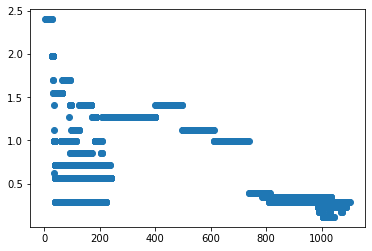

In [13]:
# import matplotlib.pyplot as plt
# %matplotlib inline

# plt.scatter(ap_d,ap_r)  # blue
# # plt.scatter(ap_xd,ap_r) # orange
# # plt.scatter(ap_yd,ap_r) # green
# # plt.scatter(ap_zd,ap_r) # red

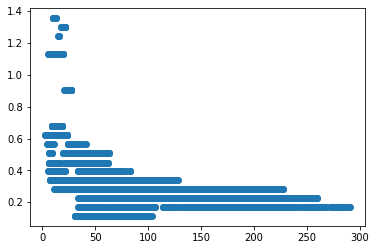

In [14]:
# plt.scatter(basal_d,basal_r)  # blue
# # plt.scatter(basal_xd,basal_r) # orange
# # plt.scatter(basal_yd,basal_r) # green
# # plt.scatter(basal_zd,basal_r) # red

In [15]:
# somaapical_r=[]
# proxapical_r=[]
# proxtrunk_r=[]
# midtrunk_r=[]
# disttrunk_r=[]
# tuft_r=[]

# for i in range(len(ap_d)):
#    if ap_d[i] < 50:
#      somaapical_r.append(ap_r[i])

#    elif ap_d[i] > 225 and ap_d[i] < 400:
#      proxtrunk_r.append(ap_r[i])

#    elif ap_d[i] > 200 and ap_d[i] < 400:
#      proxapical_r.append(ap_r[i])

#    elif ap_d[i] > 400 and ap_d[i] < 600:
#      midtrunk_r.append(ap_r[i])

#    elif ap_d[i] > 600 and ap_d[i] < 800:
#      disttrunk_r.append(ap_r[i])

#    elif ap_d[i] > 800:
#       tuft_r.append(ap_r[i])

# basal_r_avg = np.mean(basal_r)
# somaapical_r_avg = np.mean(somaapical_r)
# proxtrunk_r_avg = np.mean(proxtrunk_r)
# proxapical_r_avg = np.mean(proxapical_r)
# midtrunk_r_avg = np.mean(midtrunk_r)
# disttrunk_r_avg = np.mean(disttrunk_r)
# tuft_r_avg = np.mean(tuft_r)

# print('basal_r_avg is',basal_r_avg)
# print('somaapical_r_avg is',somaapical_r_avg)
# print('proxtrunk_r_avg is',proxtrunk_r_avg)
# print('proxapical_r_avg is',proxapical_r_avg)
# print('midtrunk_r_avg is',midtrunk_r_avg)
# print('disttrunk_r_avg is',disttrunk_r_avg)
# print('tuft_r_avg is',tuft_r_avg)

basal_r_avg is 0.2845214238628873
somaapical_r_avg is 1.1685408163265307
proxtrunk_r_avg is 1.1019278606965177
proxapical_r_avg is 0.6317466887417218
midtrunk_r_avg is 1.2564285714285712
disttrunk_r_avg is 0.6167763157894737
tuft_r_avg is 0.2720864106351551


proxbasal_r_avg is 0.39008539458186103
midbasal_r_avg is 0.2672775530839232
distbasal_r_avg is 0.2270222682547903
proxbasal_r_med is 0.34
midbasal_r_med is 0.285
distbasal_r_med is 0.225


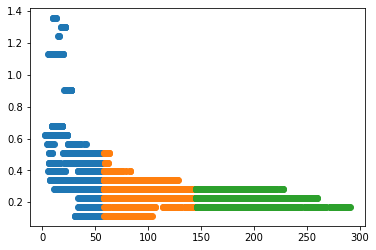

In [16]:
# basal_L=200
# proxbasal_L=40
# midbasal_L=60
# distbasal_L=100
# proxbasal_d=[]
# midbasal_d=[]
# distbasal_d=[]
# proxbasal_r=[]
# midbasal_r=[]
# distbasal_r=[]
# proxend=(proxbasal_L/basal_L)*max(basal_d)
# midend=(((proxbasal_L+midbasal_L)/basal_L)*max(basal_d))

# for i in range(len(basal_d)):
#    if basal_d[i] < proxend:
#      proxbasal_r.append(basal_r[i])
#      proxbasal_d.append(basal_d[i])

#    elif basal_d[i] > proxend and basal_d[i] < midend:
#      midbasal_r.append(basal_r[i])
#      midbasal_d.append(basal_d[i])

#    elif basal_d[i] > midend:
#      distbasal_r.append(basal_r[i])
#      distbasal_d.append(basal_d[i])


# proxbasal_r_avg = np.mean(proxbasal_r)
# midbasal_r_avg = np.mean(midbasal_r)
# distbasal_r_avg = np.mean(distbasal_r)
# proxbasal_r_med = np.median(proxbasal_r)
# midbasal_r_med = np.median(midbasal_r)
# distbasal_r_med = np.median(distbasal_r)


# print('proxbasal_r_avg is',proxbasal_r_avg)
# print('midbasal_r_avg is',midbasal_r_avg)
# print('distbasal_r_avg is',distbasal_r_avg)
# print('proxbasal_r_med is',proxbasal_r_med)
# print('midbasal_r_med is',midbasal_r_med)
# print('distbasal_r_med is',distbasal_r_med)
# plt.scatter(proxbasal_d,proxbasal_r)  # blue
# plt.scatter(midbasal_d,midbasal_r)  # blue
# plt.scatter(distbasal_d,distbasal_r) # orange

Should I section the radii by when the bars end/begin?